## Mini Project 
By: Ludovica, Inés, Andrew

### Exercise 1 
Read the content of the file and generate the correspondent graph. Choose the right type of graph and decide what you want to do with edges weights.

To understand which type of graph to generate, we looked at the description of the network in the README: 

'Each student was asked to list his 5 best female and his 5 male friends. A node represents a student and an edge between two students shows that the left student chose the right student as a friend. Higher edge weights indicate more interactions and a 0 edge weight shows that there is no common activity at all.'

We decided to use a directed graph (nx.DiGraph) with weights associated with the edges. We decided to maintain the information on the weights to be able to identify which interactions occur more frequently and constitute, therefore, a greater risk factor during the pandemic. 

In [1]:
# the data is loaded using the .read() method, which returns the content of the whole text file
with open('../out.moreno_health_health', 'rb') as infile:
    data = infile.read()
    
type(data), len(data)

(bytes, 142441)

In order to understand how to convert the input data, we used the information on the README again:

'The adjacency matrix of the network is space separated values format, with one edge per line. The meaning of the columns in out.moreno_health are:

        First column: ID of from node 
        Second column: ID of to node
        Third column: edge weight'

In [2]:
# the string is split into the content of each line, which corresponds to one edge
edges = str(data).split('\\n')

#the first 2 and the last line contain additional information that we currently do not need, and will therefore discard
list_edges = [[]]*len(edges[2:-1])
for i in range(len(edges[2:-1])):
    list_edges[i] = edges[2+i].split(' ') #each line of data is transformed into a list containing 3 elements: ID of from node,                                          
                                          #ID of to node, edge weight
    
type(list_edges), len(list_edges)

(list, 12969)

As mentioned above, the created list of lists is converted into a directed graph with weights on its edges.

In [3]:
import networkx as nx

#instantiation of the directed graph
G = nx.DiGraph()

for lst in list_edges:
    G.add_edge(lst[0], lst[1], weight=float(lst[2])) #the first element is used a the from node, the second the to node 
                                                     #and the third as the weight   
len(G)

2539

In [4]:
# saving the network to create a visualization on Gephi
nx.write_gexf(G, "./saved_graph")

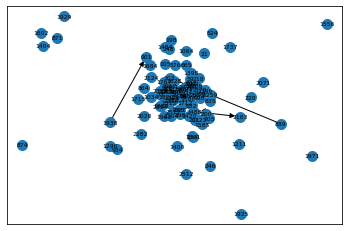

In [5]:
#since the complete visualization is too chaotic, we will visualize a random subgraph of the network
import random
randomlist = []
for i in range(100):
    n = random.randint(1,len(G))
    randomlist.append(str(n))
    
nx.draw_networkx(G.subgraph(randomlist), pos=nx.spring_layout(G), node_size=100, font_size=6) 

### Exercise 2
Given your knowledge of network analysis a school principal has approached you with the following query: "Given the current outbreak of Covid-19 we would like to secure our school. What could we do?". Use your knowledge to think about possible answers to the school principal. 

Write a short report (max 2 pages with pictures) in which you: 

(a) (2 points) Formalise the question you want to answer. The question the school principal asked is very vague. Try to make it formal enough to be studied using network theory. State the question clearly and explain why you think an answer to your question would be relevant.

(b) (6 points) Use one of the measures you have seen in the previous classes to answer the question. After you formalised your idea run some tests (you can use Python and/or Gephi) and write your endings. Make sure to present your data in a nice and understandable way. Gephi rendered graphs are welcome.

#### a) Question Formalisation

If the school principal is determined to keep the school open, we would like to, at least, slow down the rate at which the virus will spread, allowing the school to individuate and isolate the virus before the majority of the school contracts it. 

In order to do that, we will target the individuals who, due to their 'importance' in the graph, have the highest risk of spreading the virus. In so doing, we will individuate the hubs of the network (with respect to their risk factor) and evaluate whether distancing from the school these targeted individuals would be sufficient to prevent the virus from spreading too quickly. 

In other words, we will evaluate whether various degree centrality measures can detect the people with highest risk of spreading the virus. The results will be assessed on the base of how fast the virus spreads with and without these hubs and how much the distancing of these individuals from the school prevents the creation of the small world phenomenon.

To measure whether the velocity of the spread has been decreased sufficiently, we will use the following indicators:
- increased characteristic path length
- decreased how connected the graph is
- increased transitivity (favour closed groups of friends over open chains)
- increased clustering coefficient
- decreased the size and increased the number of connected components


The usefulness of this measure relies in the fact that an individual affected by the virus has an incubation period of two weeks at most. During these weeks, the virus can spread fast inside the school environment, threatening the health of a lot of families. Slowing down the spread, in conjunction with other distancing and sanitizing measures, gives the school time to individuate the problem and, using the contacts annotated in the network, trck the possibly infected individuals. 

#### b) Experiments

As a first step, let us take a look at the measures before any change is made to the network. This will provide a baseline that can be used to compare the results of the following parts. 

In [13]:
import numpy as np

char_path_length = nx.average_shortest_path_length(G)

pos_max = np.argmax([len(listElem) for listElem in sorted(nx.strongly_connected_components(G))])
char_path_length_component = [nx.average_shortest_path_length(G.subgraph(g)) for g in sorted(nx.strongly_connected_components(G))][pos_max]

density = nx.density(G)

transitivity = nx.transitivity(G)
clustering_coef = nx.average_clustering(G)

n_connected_comp = nx.number_strongly_connected_components(G)
size_connected_comp = sum([len(listElem) for listElem in sorted(nx.strongly_connected_components(G))])/len(sorted(nx.strongly_connected_components(G)))

print(f'original characteristic path length {char_path_length}, \noriginal characteristic path length of biggest component {char_path_length_component},,\noriginal network density {density},\noriginal transitivity {transitivity}, \noriginal average clustering coefficient {clustering_coef}, \noriginal number of strongly connected components {n_connected_comp}, \noriginal average size of a connected component {size_connected_comp}')

original characteristic path length 5.332392145105309, 
original characteristic path length of biggest component 6.246242139482579,,
original network density 0.00201257545412138,
original transitivity 0.14172739541160595, 
original average clustering coefficient 0.11988435473363211, 
original number of strongly connected components 368, 
original average size of a connected component 6.899456521739131


#### Experiment 1:

Using degree centrality to remove the most important nodes of the network:

In [14]:
deg_centrality = nx.degree_centrality(G)

In [26]:
G_ = G.copy()

list_nodes = G.nodes()

for node in list_nodes:
    if deg_centrality[node] > 0.0057:
        G_.remove_node(node)
        
len(G), len(G_)

(2539, 2029)

In [27]:
pos_max = np.argmax([len(listElem) for listElem in sorted(nx.strongly_connected_components(G_))])
char_path_length = [nx.average_shortest_path_length(G_.subgraph(g_)) for g_ in sorted(nx.strongly_connected_components(G_))][pos_max]

density = nx.density(G_)

transitivity = nx.transitivity(G_)
clustering_coef = nx.average_clustering(G_)

n_connected_comp = nx.number_strongly_connected_components(G_)
size_connected_comp = sum([len(listElem) for listElem in sorted(nx.strongly_connected_components(G_))])/len(sorted(nx.strongly_connected_components(G_)))

print(f'new characteristic path length {char_path_length},\nnew network density {density},\nnew transitivity {transitivity}, \nnew average clustering coefficient {clustering_coef}, \nnew number of strongly connected components {n_connected_comp}, \nnew average size of a connected component {size_connected_comp}')

new characteristic path length 9.60861573737624,
new network density 0.0014075977225690992,
new transitivity 0.09462680099664175, 
new average clustering coefficient 0.09331630145119206, 
new number of strongly connected components 598, 
new average size of a connected component 3.3929765886287626


#### Experiment 2

Using betweenness centrality to remove the most important nodes of the network:

In [18]:
between_centrality = nx.betweenness_centrality(G)

In [40]:
G_ = G.copy()

list_nodes = G.nodes()

for node in list_nodes:
    if between_centrality[node] > 0.003:
        G_.remove_node(node)
        
len(G), len(G_)

(2539, 2066)

In [23]:
pos_max = np.argmax([len(listElem) for listElem in sorted(nx.strongly_connected_components(G_))])
char_path_length = [nx.average_shortest_path_length(G_.subgraph(g_)) for g_ in sorted(nx.strongly_connected_components(G_))][pos_max]

density = nx.density(G_)

transitivity = nx.transitivity(G_)
clustering_coef = nx.average_clustering(G_)

n_connected_comp = nx.number_strongly_connected_components(G_)
size_connected_comp = sum([len(listElem) for listElem in sorted(nx.strongly_connected_components(G_))])/len(sorted(nx.strongly_connected_components(G_)))

print(f'new characteristic path length {char_path_length},\nnew network density {density},\nnew transitivity {transitivity}, \nnew average clustering coefficient {clustering_coef}, \nnew number of strongly connected components {n_connected_comp}, \nnew average size of a connected component {size_connected_comp}')

new characteristic path length 11.052121089896275,
new network density 0.0015960002718990035,
new transitivity 0.1557345008208897, 
new average clustering coefficient 0.11663489914450567, 
new number of strongly connected components 621, 
new average size of a connected component 3.3268921095008053


#### Experiment 3

Using eigen vector centrality to remove the most important nodes of the network:

In [28]:
eigen_centrality = nx.eigenvector_centrality(G)

In [38]:
G_ = G.copy()

list_nodes = G.nodes()

for node in list_nodes:
    if eigen_centrality[node] > 0.0007:
        G_.remove_node(node)
        
len(G), len(G_)

(2539, 2038)

In [39]:
pos_max = np.argmax([len(listElem) for listElem in sorted(nx.strongly_connected_components(G_))])
char_path_length = [nx.average_shortest_path_length(G_.subgraph(g_)) for g_ in sorted(nx.strongly_connected_components(G_))][pos_max]

density = nx.density(G_)

transitivity = nx.transitivity(G_)
clustering_coef = nx.average_clustering(G_)

n_connected_comp = nx.number_strongly_connected_components(G_)
size_connected_comp = sum([len(listElem) for listElem in sorted(nx.strongly_connected_components(G_))])/len(sorted(nx.strongly_connected_components(G_)))

print(f'new characteristic path length {char_path_length},\nnew network density {density},\nnew transitivity {transitivity}, \nnew average clustering coefficient {clustering_coef}, \nnew number of strongly connected components {n_connected_comp}, \nnew average size of a connected component {size_connected_comp}')

new characteristic path length 7.261922540761944,
new network density 0.0018572021141752939,
new transitivity 0.1281623906184892, 
new average clustering coefficient 0.1168912756043287, 
new number of strongly connected components 412, 
new average size of a connected component 4.946601941747573


Inspecting the degrees

In [41]:
degrees = []
for node in G.nodes():
    degrees.append(G.degree(node))
    
max(degrees), min(degrees), np.mean(degrees)

(36, 1, 10.215833005120126)

In [42]:
degrees = []
for node in G_.nodes():
    degrees.append(G_.degree(node))
    
max(degrees), min(degrees), np.mean(degrees)

(32, 0, 6.591481122942885)